In [1]:
import os
import csv
import json
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [2]:
import glob
import librosa

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024*8)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


2022-08-04 01:42:51.852958: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 01:42:51.858296: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 01:42:51.858612: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 01:42:51.859715: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

### Read in data

In [4]:
data_dir_path = '/home/jake/project/split'
data_dir_path = pathlib.Path(data_dir_path)

## New Spectro Method

In [5]:
sr = 22050 # sample rate
file_format = "wav" # or wav, ...
num_channels = 1 # mono
n_fft = 2048 # number of fft length. 2**n
win_length = 1000 # window length <= n_fft
hop_length = 250 # hopping step
n_mels = 80 # number of mels
n_mfccs = 40 # number of mfccs
preemp = .97 # preemphasis rate
n_iter = 50 # Griffin-Lim's law

## Original Spectro

In [75]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [52]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

In [53]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)


In [54]:
def process_path(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    spectrogram = get_spectrogram(waveform)
    return spectrogram, label

In [76]:
get_spectrogram(test_audio)

InvalidArgumentError: ConcatOp : Dimension 1 in both shapes must be equal: shape[0] = [16000,1] vs. shape[1] = [0,15999] [Op:ConcatV2] name: concat

In [ ]:
######

In [6]:
test_file = '/home/jake/project/split/val/sigh/f1961_0_sigh.wav'

In [8]:
test_file = tf.io.read_file('/home/jake/project/split/val/sigh/f1961_0_sigh.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([64171, 1])

In [9]:
test_audio = tf.squeeze(test_audio, axis=-1)

In [10]:
# TF
def preemphasize(y, rate=.97):
    '''
    y: 1-D tensor. Waveform.
    rate: A python scalar.
    '''
    y = tf.concat((y[:1], y[1:]-rate*y[:-1]), -1)
    return y

test_audio = preemphasize(test_audio, preemp)

In [11]:
# TF
def get_spectrograms(y, sr=22050, n_fft=2048, win_length=2048, hop_length=512, n_mels=None, power=1):
    linear = tf.signal.stft(y, frame_length=win_length, frame_step=hop_length, fft_length=n_fft) # linear spectrogram
    mag = tf.abs(linear) # magnitude
    
    if n_mels is not None:
        mel_basis = tf.convert_to_tensor(librosa.filters.mel(sr, n_fft, n_mels), tf.float32)
        mel = tf.matmul(mag**power, mel_basis, transpose_b=True) # (t, n_mels)
    else:
        mel = None
    
    return linear, mag, mel
linear, mag, mel = get_spectrograms(test_audio, sr, n_fft, win_length, hop_length, n_mels)
print(linear.eval().shape, mag.eval().shape, mel.eval().shape)

/tmp/ipykernel_74530/3382435735.py:7: FutureWarning: Pass sr=22050, n_fft=2048, n_mels=80 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_basis = tf.convert_to_tensor(librosa.filters.mel(sr, n_fft, n_mels), tf.float32)
2022-08-04 01:43:23.837034: E tensorflow/stream_executor/cuda/cuda_blas.cc:232] failed to create cublas handle: CUBLAS_STATUS_NOT_INITIALIZED
2022-08-04 01:43:23.837049: E tensorflow/stream_executor/cuda/cuda_blas.cc:234] Failure to initialize cublas may be due to OOM (cublas needs some free memory when you initialize it, and your deep-learning framework may have preallocated more than its fair share), or may be because this binary was not built with support for the GPU in your machine.
2022-08-04 01:43:23.837063: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at matmul_op_impl.h:438 : INTERNAL: Attempting to perform BLAS operation using StreamExecutor without BLAS support


InternalError: Attempting to perform BLAS operation using StreamExecutor without BLAS support [Op:MatMul]

In [56]:
######

In [57]:
data_dir_path

PosixPath('/home/jake/project/split')

In [58]:
AUTOTUNE = tf.data.AUTOTUNE

In [59]:
train_ds = tf.data.Dataset.list_files('/home/jake/project/split/train/*/*', shuffle=True)
test_ds = tf.data.Dataset.list_files('/home/jake/project/split/test/*/*', shuffle=True)
val_ds = tf.data.Dataset.list_files('/home/jake/project/split/val/*/*', shuffle=True)

In [60]:
for f in val_ds.take(5):
  print(f.numpy())


b'/home/jake/project/split/val/sigh/f1961_0_sigh.wav'
b'/home/jake/project/split/val/sniff/f0605_0_sniff.wav'
b'/home/jake/project/split/val/sniff/m3289_0_sniff.wav'
b'/home/jake/project/split/val/sigh/m0846_0_sigh.wav'
b'/home/jake/project/split/val/cough/f0835_0_cough.wav'


In [61]:
train_path = pathlib.Path('/home/jake/project/split/train/')

In [62]:
class_names = np.array(sorted([item.name for item in train_path.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)


['cough' 'laughter' 'sigh' 'sneeze' 'sniff' 'throatclearing']


In [63]:
#######

In [64]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)


(None, None)
(None, None)
(None, None)


In [65]:
print(f'Train: {len(train_ds)}')
print(f'Test: {len(test_ds)}')
print(f'Validation: {len(val_ds)}') 

Train: 15531
Test: 3591
Validation: 1855


In [66]:
for image, label in test_ds.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())



Image shape:  (38, 129, 1)
Label:  4
Image shape:  (38, 129, 1)
Label:  0
Image shape:  (38, 129, 1)
Label:  0
Image shape:  (38, 129, 1)
Label:  3
Image shape:  (38, 129, 1)
Label:  5


### Process Data

In [67]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

In [68]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())


Image shape:  (38, 129, 1)
Label:  0


In [69]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)


### Visualize Data

2022-08-04 01:22:32.636993: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


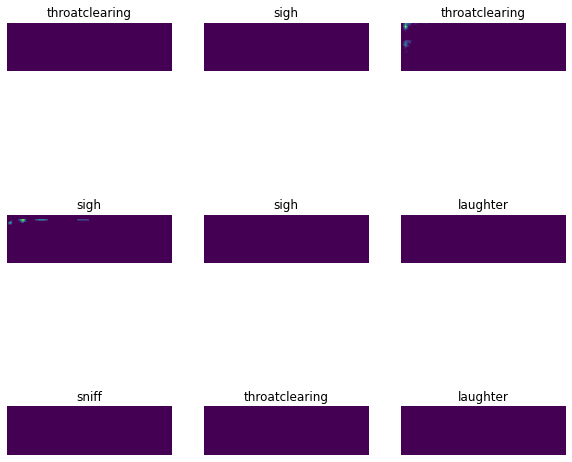

In [70]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")


In [32]:
print(image_batch.shape)
print(label_batch.shape)



(32, 124, 129, 1)
(32,)


### Create Network

In [34]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [35]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


6.8790045e-09 0.035768136


2022-08-04 01:01:12.796369: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [36]:
first_image.shape

TensorShape([124, 129, 1])

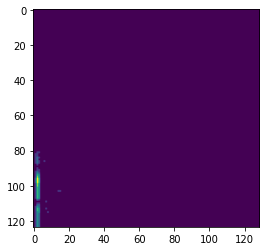

In [37]:
plt.imshow(image.numpy().astype("uint8"))

In [30]:
#AUTOTUNE = tf.data.AUTOTUNE

#train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


num_classes = 6

model = tf.keras.Sequential([
  #tf.keras.Input(shape=(None,129,1)),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 1, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 1, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 1, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])



model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


### Train Network

In [40]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=(124,129,1)))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Conv2D(64,(3,3), activation='relu'))

In [47]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 122, 127, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 61, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 28, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 48384)             0

In [46]:
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64,activation='relu'))
model.add(tf.keras.layers.Dense(6,activation='softmax'))

In [48]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [50]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50
)


Epoch 1/50
486/486 [==============================] - 2s 5ms/step - loss: 0.9943 - accuracy: 0.5984 - val_loss: 1.5177 - val_accuracy: 0.4863
Epoch 2/50
486/486 [==============================] - 2s 5ms/step - loss: 0.8789 - accuracy: 0.6480 - val_loss: 1.7635 - val_accuracy: 0.4889
Epoch 3/50
486/486 [==============================] - 2s 5ms/step - loss: 0.7888 - accuracy: 0.6852 - val_loss: 1.9973 - val_accuracy: 0.4819
Epoch 4/50
486/486 [==============================] - 2s 5ms/step - loss: 0.7015 - accuracy: 0.7187 - val_loss: 2.2374 - val_accuracy: 0.4685
Epoch 5/50
486/486 [==============================] - 2s 5ms/step - loss: 0.6411 - accuracy: 0.7521 - val_loss: 2.6383 - val_accuracy: 0.4598
Epoch 6/50
486/486 [==============================] - 2s 5ms/step - loss: 0.5894 - accuracy: 0.7713 - val_loss: 2.7222 - val_accuracy: 0.4744
Epoch 7/50
486/486 [==============================] - 2s 5ms/step - loss: 0.5407 - accuracy: 0.7923 - val_loss: 3.2466 - val_accuracy: 0.4798
Epoch 

### Validate Network